In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from transformers import T5Tokenizer, T5Model

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import os
from tqdm import tqdm
import math
import re
import random
from termcolor import colored
import dataframe_image as dfi
import warnings
import wandb
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from IPython.display import Audio, display
def allDone():
    display(Audio(url='https://www.mediacollege.com/downloads/sound-effects/beep/beep-10.wav', autoplay=True))

embed_path = './data_test'
result_path = './predicted_results'

In [2]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /Users/acetylcoa/.netrc


True

In [3]:
wandb.init(project = 'first_wandb_project')

wandb: Currently logged in as: weininglin. Use `wandb login --relogin` to force relogin


In [4]:
wandb.config.dropout = 0.1
wandb.config.hidden_layer_size = 768

In [21]:
protein_seq = pd.read_csv('./data/sequence_for_embedding_3w.csv')

In [22]:
# add space between each amino aicds
protein_seq['wt_seq'] = protein_seq['wt_seq'].apply(lambda x: ' '.join(x)).apply(
        lambda x: re.sub(r"[UZOB]", "X", x))
protein_seq['mt_seq'] = protein_seq['mt_seq'].apply(lambda x: ' '.join(x)).apply(
        lambda x: re.sub(r"[UZOB]", "X", x))

In [23]:
protein_seq['label'].astype(str)

0        0
1        0
2        0
3        0
4        0
        ..
32025    0
32026    0
32027    1
32028    1
32029    1
Name: label, Length: 32030, dtype: object

In [24]:
protein_seq['label'].value_counts()

0    24550
1     7480
Name: label, dtype: int64

In [25]:
label_names = set(protein_seq['label'])

In [14]:
list(label_names)

[0, 1]

In [15]:
set(protein_seq['label'][:109])

{0, 1}

In [16]:
protein_seq = protein_seq.head(30)

In [17]:
seq = protein_seq

In [18]:
seq[seq['Length'] == 2671]

,gene_id,aa_index,Length,wt,mt,wt_seq,mt_seq,label


In [19]:
seq = protein_seq.iloc[23302]

IndexError: single positional indexer is out-of-bounds

In [14]:
seq

,gene_id,aa_index,Length,wt,mt,wt_seq,mt_seq,label,pdb_id,AlphaFoldDB
0,NP_938073.1,123,642,N,S,M Q P R S E R P A G R T Q S P E H G S P G P G ...,M Q P R S E R P A G R T Q S P E H G S P G P G ...,0.0,6HRL,Q6TDP4
1,NP_005092.1,21,165,S,N,M G W D L T V K M L A G N E F Q V S L S S S M ...,M G W D L T V K M L A G N E F Q V S L S N S M ...,0.0,1Z2M,P05161
2,NP_005092.1,83,165,S,N,M G W D L T V K M L A G N E F Q V S L S S S M ...,M G W D L T V K M L A G N E F Q V S L S S S M ...,0.0,1Z2M,P05161
3,NP_005092.1,141,165,G,S,M G W D L T V K M L A G N E F Q V S L S S S M ...,M G W D L T V K M L A G N E F Q V S L S S S M ...,0.0,1Z2M,P05161
4,NP_005092.1,164,165,R,P,M G W D L T V K M L A G N E F Q V S L S S S M ...,M G W D L T V K M L A G N E F Q V S L S S S M ...,0.0,1Z2M,P05161
...,...,...,...,...,...,...,...,...,...,...
21146,NP_001354.1,486,514,G,R,M A D A E V I I L P K K H K K K K E R K S L P ...,M A D A E V I I L P K K H K K K K E R K S L P ...,0.0,7BGB,O60832
21147,NP_002427.1,61,466,V,F,M T L K A S E G E S G G S M H T A L S D L Y L ...,M T L K A S E G E S G G S M H T A L S D L Y L ...,0.0,2EJY,Q00013
21148,NP_741995.1,192,213,G,R,M E A I W L Y Q F R L I V I G D S T V G K S C ...,M E A I W L Y Q F R L I V I G D S T V G K S C ...,1.0,6S5F,Q96DA2
21149,NP_741995.1,168,213,T,K,M E A I W L Y Q F R L I V I G D S T V G K S C ...,M E A I W L Y Q F R L I V I G D S T V G K S C ...,1.0,6S5F,Q96DA2


## Embeddings

In [ ]:
# config
max_seq_len = 380
batch_size = 10

# CUDA
USE_CUDA = torch.cuda.is_available()

# MPS:
USE_MPS = torch.has_mps

if USE_MPS:
    torch.cuda.manual_seed(2020)
    device = torch.device('mps')
    print('Device name: MPS')
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

# if torch.cuda.is_available():       
#     device = torch.device("cuda")
#     print(f'There are {torch.cuda.device_count()} GPU(s) available.')
#     print('Device name:', torch.cuda.get_device_name(0))

# else:
#     print('No GPU available, using the CPU instead.')
#     device = torch.device("cpu")

NameError: name 'torch' is not defined

In [43]:
device = torch.device("cpu")

In [44]:
from transformers import T5Tokenizer, T5EncoderModel
tokenizer = T5Tokenizer.from_pretrained('Rostlab/prot_t5_xl_half_uniref50-enc', do_lower_case=False)
model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_half_uniref50-enc").to(device)
model = model.eval()

In [45]:
# print(model)

In [63]:
import pickle
def get_embedding(protein_seq, start=None, stop=None, save_path=embed_path):
    
    xs = []
    result = None
    count = 0
    embed_error_count = 0
    protein_seq = protein_seq[start:stop]
    data_len = len(protein_seq)

    for index, seq in tqdm(protein_seq.iterrows(), total=protein_seq.shape[0]):
        s_len = len(seq['wt_seq'].replace(" ",'')) + 1
        aa_index = seq['aa_index']
        label = seq['label']
        wt_aa = seq['wt']
        mt_aa = seq['mt']
        wt_seq = seq['wt_seq']
        mt_seq = seq['mt_seq']
        # AF_DB = seq['AlphaFoldDB']
        # PDB = seq['PDB']
        # pathogenicity = seq['pathogenicity']
        
        # add_special_tokens adds extra token at the end of each sequence
        token_encoding = tokenizer.batch_encode_plus([seq['wt_seq'], seq['mt_seq']], add_special_tokens=True, padding="longest")
        input_ids      = torch.tensor(token_encoding['input_ids']).to(device)
        attention_mask = torch.tensor(token_encoding['attention_mask']).to(device)

        with torch.no_grad():
            # returns: ( batch-size x max_seq_len_in_minibatch x embedding_dim )
            embedding_repr =model(input_ids, attention_mask=attention_mask)
            emb = embedding_repr.last_hidden_state[:, :s_len]
            emb = emb[:, aa_index, :]
            print(emb)
            print(emb.shape)
            print(emb.keys())
            break
            # try:
            #     emb = emb[:, aa_index, :]
            # except:
            #     embed_error_count += 1
            #     print(f'embedding error: index: {index}, aa_index:{aa_index}, aa_length: {s_len} , error_count:{embed_error_count}')
                
            # print(aa_index)
            x = emb.detach().cpu().numpy().squeeze()
           
            temp = pd.DataFrame({
                'label':label,
                'mutant_index': aa_index,
                'wt_aa': wt_aa,
                't_aa': mt_aa,
                'wt_seq': wt_seq,
                'mt_seq': mt_seq,
                'wt_emb': [x[0, :]],
                'mt_emb':[x[1,:]],
                # 'AF_DB': AF_DB,
                # 'PDB_ID': PDB
            })
            
            if result is None:
                result=temp
            else:
                result = pd.concat([result,temp])

            xs.append({'x':x.reshape(1,-1), 'label':label})
            
    # Save results
#     if not os.path.isdir(f'{save_path}'):
#         os.mkdir(f'{save_path}')
            
#     if start is None:
#         result.to_csv(f'{save_path}/sequence_embeddings({data_len}).csv', index=False)
#         with open(f'./data_test/emb({data_len}).pkl', 'wb') as f:
#             pickle.dump(xs, f)
#     else:
#         result.to_csv(f'{save_path}/sequence_{stop}_embeddings.csv', index=False)
#         with open(f'{save_path}/emb_{stop}.pkl', 'wb') as f:
#             pickle.dump(xs, f)
    
# get_embedding(seq)  
    

In [38]:
protein_seq = protein_seq[:39]

In [163]:
len(protein_seq)

39

In [164]:
value_input = 10
data_len = len(protein_seq)

In [165]:
data_len // value_input

3

In [166]:
remainder = data_len - data_len % value_input

In [167]:
remainder

30

In [47]:
def embed_in_batch(protein_seq, amount):
    value_input = amount
    data_len = len(protein_seq)
    fold = data_len // value_input
    remainder = data_len - data_len % value_input

    for i in range(fold):
        get_embedding(protein_seq,  start = i* value_input, stop = (i+1)*value_input)
    
    get_embedding(protein_seq, start = remainder, stop = data_len)

In [64]:
embed_in_batch(protein_seq[0:50],5)

  0%|                                                                                                                           | 0/5 [00:04<?, ?it/s]

tensor([[-0.0519,  0.0301,  0.1870,  ...,  0.0954, -0.0625, -0.0733],
        [-0.0597,  0.0104,  0.2113,  ...,  0.1198, -0.1021, -0.0815]])
torch.Size([2, 1024])


AttributeError: 'Tensor' object has no attribute 'keys'

In [50]:
get_embedding(protein_seq[0])

KeyError: 0

In [51]:
# for i in range(fold):
#     print(i* value_input, (i+1)*value_input - 1)
# print(len(protein_seq) - len(protein_seq) % value_input, len(protein_seq))

In [5]:
# read residue_embeddings
import pickle

with open('emb_19.pkl', 'rb') as file:
    y_19 = pickle.load(file)

FileNotFoundError: [Errno 2] No such file or directory: 'emb_19.pkl'

In [10]:
data_y = []
data_X = []
for i in range(len(y)):
    data_X.append(y[i]['x'][0])
    data_y.append(int(y[i]['label']))

NameError: name 'y' is not defined

In [1]:
import os
import pickle
import numpy as np
def data_for_downstream():
    path = os.getcwd() + '/data_test/model_1/'
    concat = []
    for pkl in os.listdir(path):
        if(".pkl" in pkl):
            file_path = path + pkl
            with open(file_path, 'rb') as file:
                y = pickle.load(file)
                concat += y
    data_y = []
    data_X = []
    for i in range(len(concat)):
        data_X.append(concat[i]['x'][0])
        data_y.append(int(concat[i]['label']))
    data_X = np.array(data_X)
    return data_X, data_y

In [2]:
data_X, data_y = data_for_downstream()

In [3]:
data_X.shape, len(data_y)

((27750, 2048), 27750)

In [4]:
from sklearn.manifold import TSNE
X = data_X
X_embedded = TSNE(n_components = 2, learning_rate = 'auto', perplexity = 3).fit_transform(X)

/Users/acetylcoa/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [5]:
X_embedded.shape

(27750, 2)

In [17]:
import pandas as pd
df = pd.DataFrame({'tsne-2d-one':X_embedded[:,0], 'tsne-2d-two':X_embedded[:,1], 'label':data_y})

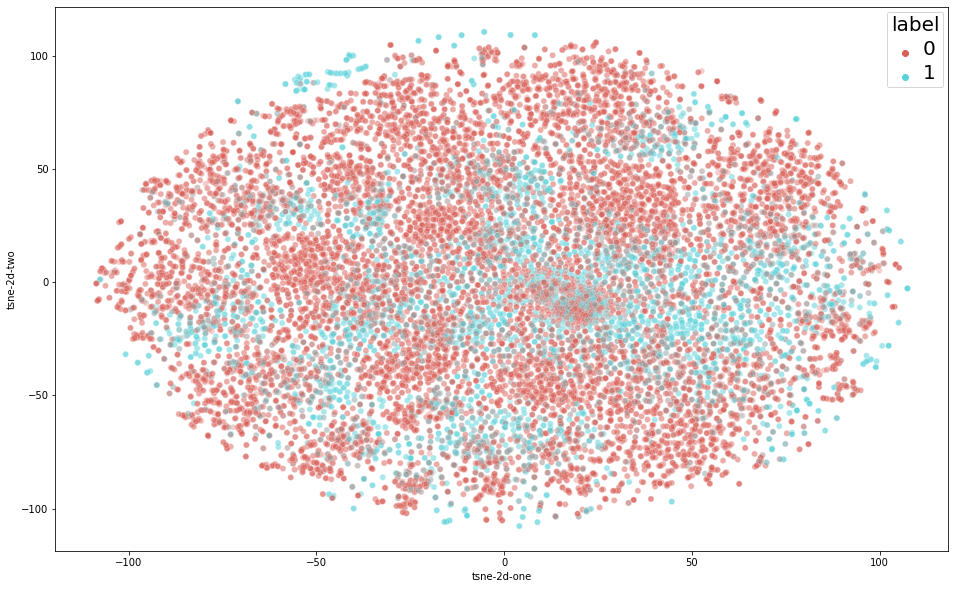

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(16,10))
plot = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue='label',
    palette=sns.color_palette("hls", 2),
    data=df,
    legend="full",
    alpha=0.3
)
# for legend text

plt.setp(plot.get_legend().get_texts(), fontsize='20') 
 
# for legend title
plt.setp(plot.get_legend().get_title(), fontsize='20') 
plt.show()

In [7]:
# data_X = np.array(data_X)
# data_X.shape

In [8]:
# 切分数据集
X_train, X_test, y_train, y_test= train_test_split(data_X, data_y,
                                                    test_size=0.2,
                                                    stratify=data_y,
                                                   random_state=42)
# # 切分出valid数据集
X_valid, X_test, y_valid, y_test = train_test_split(X_test,y_test,
                                               test_size=0.7,
                                               shuffle=True,
                                               stratify=y_test,
                                               random_state=42)

len(X_train), len(y_train),len(X_test), len(y_test), len(X_valid),len(y_valid)

(22200, 22200, 3885, 3885, 1665, 1665)

In [9]:
# from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
# from sklearn.metrics import classification_report
# rfc=RandomForestClassifier(random_state=0, n_estimators = 10)
# rfc.fit(X_train, y_train)
# y_rfc = rfc.predict(X_test)

In [10]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import classification_report

rfc = RandomForestClassifier(random_state=42, n_estimators=12)
gbt=GradientBoostingClassifier(random_state=42, n_estimators = 10)

rfc.fit(X_train, y_train)
y_rfc = rfc.predict(X_test)

gbt.fit(X_train, y_train)
y_gbt = gbt.predict(X_test)

# traditional_model(rfc,X_train,y_train,X_test,y_test)
# traditional_model(gbt,X_train,y_train,X_test,y_test)
# report_save()

In [43]:
cat_features = [1,2]

In [39]:
len(cat_features.values)

TypeError: object of type 'builtin_function_or_method' has no len()

In [14]:
from catboost import CatBoostClassifier

cbt = CatBoostClassifier(iterations=150, learning_rate=0.09, depth=6, loss_function='CrossEntropy')
cbt.fit(X_train, y_train)
y_cbt = cbt.predict(X_test)
report_save(y_test, y_cbt, 'CatBoost')

0:	learn: 0.6398157	total: 68.5ms	remaining: 10.2s
1:	learn: 0.6000198	total: 129ms	remaining: 9.56s
2:	learn: 0.5708735	total: 215ms	remaining: 10.5s
3:	learn: 0.5476511	total: 301ms	remaining: 11s
4:	learn: 0.5258159	total: 376ms	remaining: 10.9s
5:	learn: 0.5088465	total: 441ms	remaining: 10.6s
6:	learn: 0.4964039	total: 505ms	remaining: 10.3s
7:	learn: 0.4834059	total: 564ms	remaining: 10s
8:	learn: 0.4763980	total: 647ms	remaining: 10.1s
9:	learn: 0.4676634	total: 793ms	remaining: 11.1s
10:	learn: 0.4605489	total: 906ms	remaining: 11.5s
11:	learn: 0.4545369	total: 994ms	remaining: 11.4s
12:	learn: 0.4486319	total: 1.07s	remaining: 11.3s
13:	learn: 0.4445225	total: 1.16s	remaining: 11.2s
14:	learn: 0.4402693	total: 1.24s	remaining: 11.2s
15:	learn: 0.4367513	total: 1.34s	remaining: 11.2s
16:	learn: 0.4338486	total: 1.42s	remaining: 11.1s
17:	learn: 0.4298048	total: 1.49s	remaining: 10.9s
18:	learn: 0.4270686	total: 1.55s	remaining: 10.7s
19:	learn: 0.4241429	total: 1.63s	remaining:

objc[18998]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x22c519b50) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/104.0.5112.79/Libraries/libGLESv2.dylib (0x10a1c9d08). One of the two will be used. Which one is undefined.
[0810/200935.368199:INFO:headless_shell.cc(660)] Written to file /var/folders/yf/b5jj2z454vx8gz_ppz2wrtdc0000gn/T/tmpbcws376s/temp.png.


In [15]:
from xgboost import XGBClassifier
eval_s = [(X_train, y_train), (X_test, y_test)]
xgb = XGBClassifier(early_stopping_rounds=10, eval_set=eval_s, verbose=False)
xgb.fit(X_train, y_train)
y_xgb = xgb.predict(X_test)
report_save(y_test, y_xgb, 'XGBoost')

[20:09:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds", "eval_set", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

				 *** XGBoost_report ***:


               precision    recall  f1-score   support

           0       0.88      0.94      0.91      2892
           1       0.77      0.62      0.69       993

    accuracy              

objc[19034]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x22c519b50) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/104.0.5112.79/Libraries/libGLESv2.dylib (0x108061d08). One of the two will be used. Which one is undefined.
[0810/201058.053936:INFO:headless_shell.cc(660)] Written to file /var/folders/yf/b5jj2z454vx8gz_ppz2wrtdc0000gn/T/tmpqsz_lpwk/temp.png.


In [13]:
# Traditional ML training
def traditional_model(name, X_train, y_train, X_test, y_test):
    model_name = re.search(r"(.*)(\(.*)", str(name))
    model_name = model_name.group(1)

    name.fit(X_train, y_train)
    y_pred = name.predict(X_test)
    
    report_save(y_test, y_pred, model_name)
    
def report_save(y_true, y_pred, name, label_names=None, *args, **kv):
    result_path = './predicted_results'
    # print the classification report here
    report = classification_report(y_true, y_pred, target_names=label_names)
    print(colored(f'\n\t\t\t\t *** {name}_report ***:\n\n\n', 'blue', attrs=['bold']), report)

    # create report dataframe
    report_for_save = classification_report(y_true, y_pred, target_names=label_names, output_dict=True)
    report_csv = pd.DataFrame(report_for_save).transpose()

    # style.background_gradient or highlight_max
    report_styled = report_csv.style.background_gradient(subset=['precision', 'recall', 'f1-score'])

    # export dataframe to .png
    dfi.export(report_styled, f'{result_path}/{name}_report.png')

    report_csv.to_csv(f'{result_path}/{name}_report_save.csv')


In [16]:
# MCC
from sklearn.metrics import matthews_corrcoef
mcc_cbt = matthews_corrcoef(y_test,y_cbt)
mcc_xgb = matthews_corrcoef(y_test,y_xgb)
mcc_rfc = matthews_corrcoef(y_test,y_rfc)
mcc_gbt = matthews_corrcoef(y_test,y_gbt)
print(mcc_cbt)
print(mcc_xgb)
print(mcc_rfc)
print(mcc_gbt)

0.5413313753346047
0.6041045076623859
0.4745503551752935
0.29965402277438496


In [ ]:
# Traditional ML training
def traditional_model(name, X_train, y_train, X_test, y_test):

    name.fit(X_train, y_train)
    y_pred = name.predict(X_test)
    report_save(y_test, y_pred, name.upper())



In [54]:
df = pd.read_csv('df.csv')

In [55]:
df

,Model_name,MCC
0,XG Boost,0.604105
1,Cat Boost,0.541331
2,Random Forest,0.474550
3,Gradient Boost,0.299654


[Text(0, 0.5, 'MCC score'), Text(0.5, 0, 'Models')]

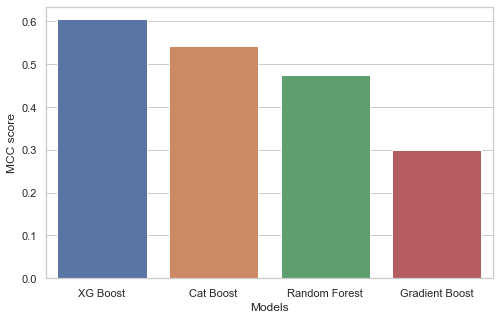

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(8,5))
sns.set_theme(style="whitegrid")
sns.barplot(x='Model_name', y ='MCC', data=df)
ax.set(ylabel="MCC score",
       xlabel="Models")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))
# x and y are lists
sns.barplot(x=x, y=y, color='goldenrod', ax=ax, label="Some Label")
ax.set_xlabel("X-Label")
ax.set_ylabel("Y-Label")
ax.legend()
plt.show()

In [22]:
protein_test = protein_seq[:50]

In [18]:
input_ids = []
attention_masks = []

In [19]:
type(attention_masks)

list

In [20]:
for index, seq in protein_seq.iterrows():
    
    # add_special_tokens adds extra token at the end of each sequence
    token_encoding = tokenizer.batch_encode_plus([seq['wt_seq'], seq['mt_seq']], add_special_tokens=True, padding="longest")
    input_ids.append(token_encoding['input_ids'])
    attention_masks.append(token_encoding['attention_mask'])

# input_ids = torch.cat(input_ids, dim = 0)
# attention_masks = torch.cat(attention_masks, dim = 0)




In [23]:
for index, seq in protein_test.iterrows(): 
    # add_special_tokens adds extra token at the end of each sequence
    token_encoding = tokenizer.batch_encode_plus([seq['wt_seq'], seq['mt_seq']], add_special_tokens=True, padding="longest")
    input_ids      = torch.tensor(token_encoding['input_ids']).to(device)
    attention_masks = torch.tensor(token_encoding['attention_mask']).to(device)

In [24]:
wt_token_encoding = tokenizer.batch_encode_plus(protein_seq['wt_seq'], add_special_tokens=True, padding="longest")
mt_token_encoding = tokenizer.batch_encode_plus(protein_seq['mt_seq'], add_special_tokens=True, padding="longest")
    

In [59]:
type(wt_tensor)

torch.Tensor

In [ ]:
wt_tensor = torch.tensor(wt_token_encoding['input_ids'])
wt_mask = torch.tensor(wt_token_encoding['attention_mask'])

mt_tensor = torch.tensor(mt_token_encoding['input_ids'])
mt_mask = torch.tensor(mt_token_encoding['attention_mask'])

label = torch.tensor(protein_seq['label'].tolist())

In [ ]:
input_ids = torch.cat((wt_tensor,mt_tensor), -1)
attention_masks = torch.cat((wt_mask,mt_mask),-1)

### DataLoader

In [ ]:
batch_size = 2

In [64]:
dataset = TensorDataset(input_ids, attention_masks, label)
dataloader = DataLoader(dataset, batch_size = batch_size)

In [71]:

# train_pbar = tqdm(trainloader, position=0, leave=True)

for batch_idx, batch in dataloader:
    with torch.no_grad():
        s_len,x = zip(*batch)
        print(s_len,x)
        break
#         b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
#         # returns: ( batch-size x max_seq_len_in_minibatch x embedding_dim )
#         embedding_repr = model(b_input_ids, b_attn_mask)
#         emb = embedding_repr.last_hidden_state[batch_idx,:s_len]
#         emb = emb[:, aa_index, :]
#         # print(aa_index)
#         x = emb.detach().cpu().numpy().squeeze()

#     b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
#     pred = model(b_input_ids, b_attn_mask)
  
# with torch.no_grad():
#             # returns: ( batch-size x max_seq_len_in_minibatch x embedding_dim )
#             embedding_repr = model(input_ids, attention_mask=attention_mask)
#             emb = embedding_repr.last_hidden_state[:, :s_len]
#             emb = emb[:, aa_index, :]
#             # print(aa_index)
#             x = emb.detach().cpu().numpy().squeeze()

    

ValueError: too many values to unpack (expected 2)

In [ ]:
get_embedding(protein_test)  